In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt 
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import jarque_bera

In [5]:
# Define the ticker symbol for the Shanghai Composite Index
ticker = '000001.SS'

# Define the date range
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download the full dataset sourced from yahoo finance
data = yf.download(ticker, start=start_date, end=end_date)

# Print some samples
print(pd.concat([data.head(1), data.tail(1)]))

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-01-02  2112.125977  2113.110107  2101.016113  2109.386963  2109.386963   
2023-12-29  2950.836914  2975.031982  2950.017090  2974.935059  2974.935059   

            Volume  
Date                
2014-01-02   68500  
2023-12-29  290700  


Train: 1944, Test: 487


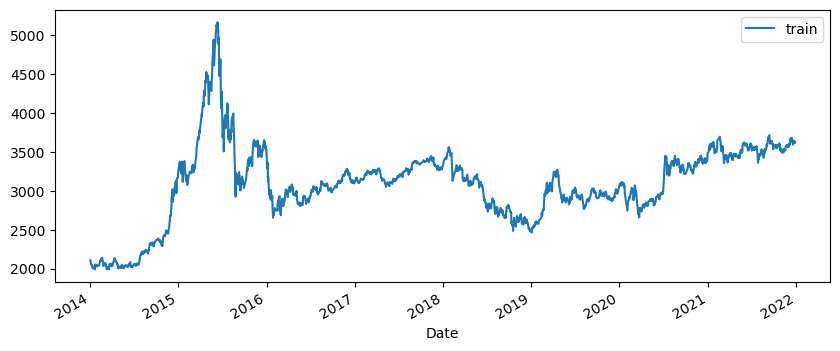

In [8]:
# Define a function for train-test split
def train_test_split(X, size=0.8):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

# Split train set and test set
train, test = train_test_split(X=data['Close'], size=0.8)
print(f'Train: {len(train)}, Test: {len(test)}')


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


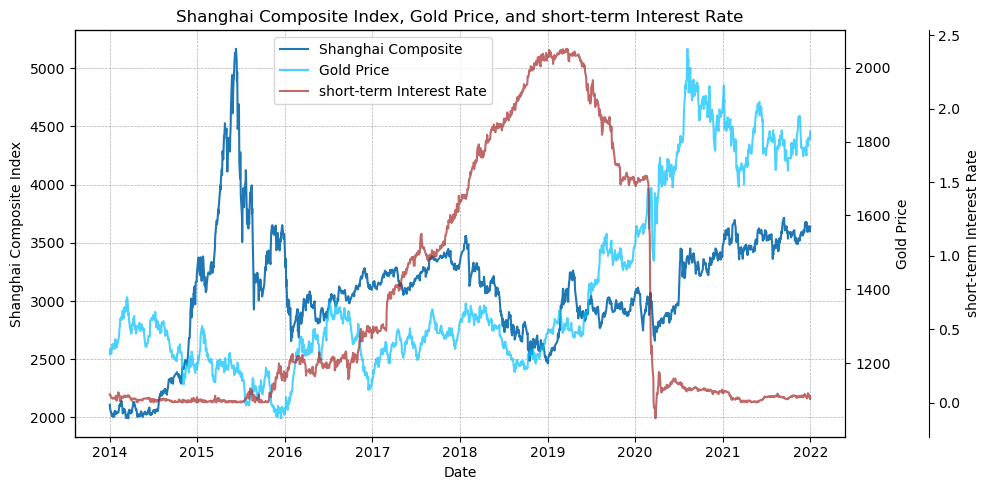

In [21]:
# Define the ticker symbols for the Shanghai Composite Index, Gold, and Interest Rate
ticker_shanghai = '000001.SS'
ticker_gold = 'GC=F'
ticker_interest_rate = '^IRX'

# Define the date range
start_date = '2014-01-01'
end_date = '2022-01-01'

# Download the data for all three indices
data_shanghai = yf.download(ticker_shanghai, start=start_date, end=end_date)
data_gold = yf.download(ticker_gold, start=start_date, end=end_date)
data_interest_rate = yf.download(ticker_interest_rate, start=start_date, end=end_date)

# Synchronize the dates by joining the data on dates
data = pd.DataFrame({
    'Shanghai Composite': data_shanghai['Close'],
    'Gold Price': data_gold['Close'],
    'Interest Rate': data_interest_rate['Close']
}).dropna()

# Plot all datasets on the same graph with different y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Shanghai Composite Index on the primary y-axis
ax1.plot(data.index, data['Shanghai Composite'], color='#1f77b4', label='Shanghai Composite')
ax1.set_xlabel('Date', color='black')
ax1.set_ylabel('Shanghai Composite Index', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.tick_params(axis='x', labelcolor='black')

# Add horizontal gridlines to the plot
ax1.grid(True, linestyle='--', linewidth=0.5)

# Create a second y-axis to plot Gold prices
ax2 = ax1.twinx()
ax2.plot(data.index, data['Gold Price'], color='#00bfff', label='Gold Price', alpha=0.7) 
ax2.set_ylabel('Gold Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Create a third y-axis to plot Interest Rate
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to the right
ax3.plot(data.index, data['Interest Rate'], color='brown', label='short-term Interest Rate', alpha=0.7)
ax3.set_ylabel('short-term Interest Rate', color='black')
ax3.tick_params(axis='y', labelcolor='black')

# Set both axes numbers to black
ax1.yaxis.label.set_color('black')
ax2.yaxis.label.set_color('black')
ax3.yaxis.label.set_color('black')

# Add title and legends
plt.title('Shanghai Composite Index, Gold Price, and short-term Interest Rate', color='black')

# Add legend and adjust position
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left', bbox_to_anchor=(0.25, 1))  # Adjust position here

fig.tight_layout()
plt.show()

In [7]:
# Descriptive statistics
def descriptive_statistics(train):
    mean = train.mean()
    median = train.median()
    maximum = train.max()
    minimum = train.min()
    std_dev = train.std()
    skewness = train.skew()
    kurtosis = train.kurtosis()
    jb_test = jarque_bera(train)
    
    desc_stats = {
        'Mean': mean,
        'Median': median,
        'Maximum': maximum,
        'Minimum': minimum,
        'Std. Dev.': std_dev,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Jarque-Bera': jb_test[0],
        'Probability': jb_test[1]
    }
    
    return desc_stats

# ARCH-LM test
def arch_lm_test(train, lags):
    result = het_arch(train, maxlag=lags)
    return result

# ADF test
def adf_test(train):
    result = adfuller(train)
    return result[0], result[1]

# Phillips-Perron test (similar to KPSS)
def pp_test(train):
    result = kpss(train, regression='c')
    return result[0], result[1]

# Implementing the functions on the train set
desc_stats = descriptive_statistics(train)

# ARCH-LM test at different lags
arch_lm_1 = arch_lm_test(train, lags=1)
arch_lm_5 = arch_lm_test(train, lags=5)
arch_lm_10 = arch_lm_test(train, lags=10)

# ADF test
adf_stat, adf_pvalue = adf_test(train)

# Phillips-Perron test
pp_stat, pp_pvalue = pp_test(train)

# Number of observations
n_obs = len(train)

# Compiling the results
results = {
    **desc_stats,
    'ARCH-LM (1)': arch_lm_1[0],
    'ARCH-LM (5)': arch_lm_5[0],
    'ARCH-LM (10)': arch_lm_10[0],
    'ADF': adf_stat,
    'Phillips-Perron': pp_stat,
    'Observations': n_obs
}

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, index=[0])
print(results_df)

         Mean       Median      Maximum      Minimum   Std. Dev.  Skewness  \
0  3091.60847  3114.731079  5166.350098  1991.253052  498.172902  0.185243   

   Kurtosis  Jarque-Bera   Probability  ARCH-LM (1)  ARCH-LM (5)  \
0  1.736087   253.116939  1.087314e-55  1921.921507  1918.787938   

   ARCH-LM (10)       ADF  Phillips-Perron  Observations  
0   1914.005618 -2.642783         0.773056          1944  


C:\Users\p0f3h\AppData\Local\Temp\ipykernel_17232\3527878990.py:28: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  result = het_arch(train, maxlag=lags)
c:\Users\p0f3h\anaconda3\envs\2024project\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
